# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('always')
from sklearn.model_selection import train_test_split
import shapely.speedups
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import re

In [2]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()

# 1.Procesamiento del Lenguaje Natural

## a) Ampliación del dataset

In [3]:
#dataset.head()
#dataset.minqing_hu()

## b) Modelos

# 2. Redes Neuronales

## Regresión:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

np.random.seed(1)
tf.random.set_seed(1)

c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [5]:
viviendas_train.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,49.0,167113.0,Departamento - Saavedra,POINT (-58.4905135 -34.5550487)
1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,44.0,129000.0,Departamento - Saavedra,POINT (-58.4785532 -34.546991)
2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,58.0,124600.0,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421)
3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,60.0,196000.0,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511)
4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,61.0,235000.0,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899)


HACEr ONE HOT ENCODINFG CON LAS COLUMNAS NO NUMERICAs

**Realizamos Encoding**

para variable property_type y barrio

In [6]:
from sklearn.preprocessing import LabelEncoder
viviendas_caba_encoded = viviendas_train.copy()
viviendas_caba_encoded['property_type'] = LabelEncoder().fit_transform(viviendas_train['property_type'])
viviendas_caba_encoded['barrio'] = LabelEncoder().fit_transform(viviendas_train['barrio'])
viviendas_caba_encoded.head(2)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-12-15,2021-12-25,-34.555049,-58.490513,37,1,2.0,1.0,58.0,49.0,167113.0,Departamento - Saavedra,POINT (-58.4905135 -34.5550487)
1,2021-05-20,2021-06-05,-34.546991,-58.478553,37,1,2.0,1.0,48.0,44.0,129000.0,Departamento - Saavedra,POINT (-58.4785532 -34.546991)


In [7]:
dataset_trabajo=viviendas_caba_encoded[['latitud', 'longitud', 'barrio','property_type','property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price']]


#A BORRAR
dataset_trabajo = dataset_trabajo[:2000]

In [8]:
dataset_trabajo.head()

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.555049,-58.490513,37,1,2.0,1.0,58.0,49.0,167113.0
1,-34.546991,-58.478553,37,1,2.0,1.0,48.0,44.0,129000.0
2,-34.570842,-58.491805,55,1,2.0,1.0,62.0,58.0,124600.0
3,-34.589251,-58.402106,35,1,3.0,2.0,60.0,60.0,196000.0
4,-34.626290,-58.437632,9,1,3.0,2.0,67.0,61.0,235000.0


In [9]:
columnas_predictoras=dataset_trabajo.columns.to_list()
columnas_predictoras.remove('property_price')
columnas_predictoras

['latitud',
 'longitud',
 'barrio',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered']

In [10]:
variables_predictoras=['latitud','longitud', 'property_surface_total', 'property_surface_covered']
#X = surf_tot, Y = price
x_train, x_test, y_train, y_test = train_test_split(dataset_trabajo.loc[:,variables_predictoras],dataset_trabajo.loc[:,'property_price'],test_size=0.2)

In [11]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(x_train))

StandardScaler()

In [12]:
x_train_transform=sscaler.transform(pd.DataFrame(x_train))
x_test_transform=sscaler.transform(pd.DataFrame(x_test))

#### Modelo 1

In [13]:
# Creo un modelo Red Neuronal
d_in=4
d_out=1

modelo1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,))]) #, activation="relu"

In [14]:
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [15]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

50/50 [==============================] - 0s 516us/step


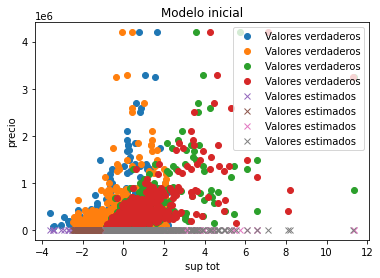

In [16]:
plot_regression(modelo1,x_train_transform,y_train,title=f"Modelo inicial",xlabel="sup tot",ylabel="precio")

In [17]:
modelo1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  metrics=['mae'], 
)

In [18]:
# Entrenamiento del modelo
modelo1.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

Miremos como la red aprendio los datos con los que fue entrenada

50/50 [==============================] - 0s 430us/step


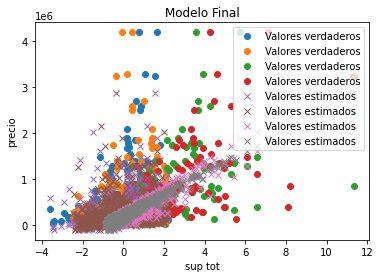

In [19]:
plot_regression(modelo1,x_train_transform,y_train,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

Miremos como la red predice

13/13 [==============================] - 0s 582us/step


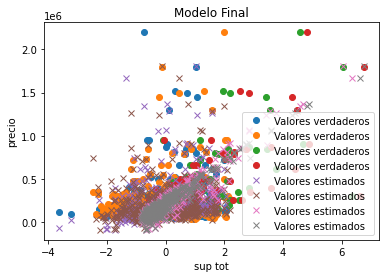

In [20]:
plot_regression(modelo1,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

In [21]:
y_pred_modelo1=modelo1.predict(x_test_transform)

mae_modelo1=mean_absolute_error(y_test,y_pred_modelo1)
mse_modelo1=mean_squared_error(y_test,y_pred_modelo1)

print(f"Error absoluto medio {mae_modelo1}")
print(f"Error cuadrático medio {mse_modelo1}")
print(f"rmse {mse_modelo1**(1/2)}")

13/13 [==============================] - 0s 585us/step
Error absoluto medio 73233.60970703125
Error cuadrático medio 20427284400.000195
rmse 142924.0511600486


#### Modelo 2

In [22]:
# Creo un modelo Red Neuronal
d_in=4
d_out=1

modelo2 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(2, activation="tanh" ),
    keras.layers.Dense(d_out, )])

In [23]:
modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelo2.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['mae'], 
)

In [25]:
# Entrenamiento del modelo
modelo2.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

Este es el numero de veces que se ejecutaran los algoritmos de forwardpropagation y backpropagation. En cada ciclo (epoch) todos los datos de entrenamiento pasan por la red neuronal para que esta aprenda sobre ellos, si existen 10 ciclos y 1000 datos, cada ciclo los 1000 datos pasaran por la red neuronal. Si se especifica el parametro batch size cada ciclo (epoch) tendra más ejecuciones internas, estas ejecuciones se llaman iteraciones, si tenemos un batch size de 100, se tendran 10 iteraciones para completar un ciclo, en cada iteración se ejecutan los algoritmos de forwardpropagation y backpropagation, de esta manera la red neuronal actualiza más veces los parametros W (pesos) y b (bias).

Verificamos cómo aprendio los datos de entrenamiento

50/50 [==============================] - 0s 533us/step


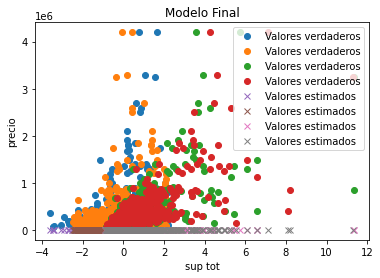

In [26]:
plot_regression(modelo2,x_train_transform,y_train,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

Evaluamos el modelo en el dataset de test

13/13 [==============================] - 0s 499us/step


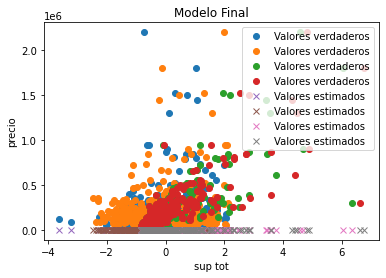

In [27]:
plot_regression(modelo2,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

In [28]:
y_pred=modelo2.predict(x_test_transform)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"rmse {mse**(1/2)}")

13/13 [==============================] - 0s 624us/step
Error absoluto medio 214442.7830417824
Error cuadrático medio 101453105356.92746
rmse 318517.04092077626


#### Modelo3

13/13 [==============================] - 0s 655us/step


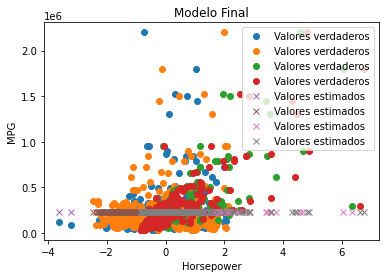

In [29]:
# Creo un modelo Red Neuronal
d_in=4
d_out=1

modelo3 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu" ),
    keras.layers.Dense(d_out, )])

modelo3.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.1), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['mae'], 
)

modelo3.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

plot_regression(modelo3,x_test_transform,y_test,title=f"Modelo Final",xlabel="Horsepower",ylabel="MPG")

In [35]:
def intento(parametro):
    d_in=4
    d_out=1

    modelo3 = keras.Sequential([
        # input_shape solo en la primer capa
        # Capa con 2 salidas, activación relu
        keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
        # Capa con 50 salidas, activación tanh
        keras.layers.Dense(50, activation="relu" ),



        keras.layers.Dense(d_out, )])

    modelo3.compile(
    optimizer= parametro, 
    loss='mse', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=['mae'], 
    )

    modelo3.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

    #plot_regression(modelo3,x_test_transform,y_test,title=f"Modelo Final",xlabel="Horsepower",ylabel="MPG")

    y_pred=modelo3.predict(x_test_transform)
    mse=mean_squared_error(y_test,y_pred)
    return mse ** (1/2)
    

In [36]:
params_grid = [keras.optimizers.SGD(learning_rate=0.1), 
    keras.optimizers.RMSprop(learning_rate=0.1),
    keras.optimizers.Adamax(learning_rate=0.1),
    keras.optimizers.Nadam(learning_rate=0.1),
    keras.optimizers.Adadelta(learning_rate=0.1),
    
    keras.optimizers.RMSprop(learning_rate=0.01),
    keras.optimizers.Adamax(learning_rate=0.01),
    keras.optimizers.Nadam(learning_rate=0.01),
    keras.optimizers.Adadelta(learning_rate=0.01),
    
    ]

In [37]:
def crossValidation(parametros, funcion):
    resultados = []
    for j in range(len(parametros)-1):
        print(j)
        resultados.append(funcion(parametros[j]))
    return resultados

In [38]:

resultados = crossValidation(params_grid, intento)


0
13/13 [==============================] - 0s 682us/step
1
13/13 [==============================] - 0s 621us/step
2
13/13 [==============================] - 0s 665us/step
3
13/13 [==============================] - 0s 748us/step
4
13/13 [==============================] - 0s 565us/step
5
13/13 [==============================] - 0s 635us/step
6
13/13 [==============================] - 0s 665us/step
7
13/13 [==============================] - 0s 748us/step


In [39]:
for i in range(len(params_grid)-1):
    print(f'El modelo {params_grid[i]} dio en la metrica rmse {resultados[i].round()}')

El modelo <keras.optimizers.optimizer_v2.gradient_descent.SGD object at 0x0000015CAE691040> dio en la metrica rmse 236391.0
El modelo <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x0000015CAE6910A0> dio en la metrica rmse 122258.0
El modelo <keras.optimizers.optimizer_v2.adamax.Adamax object at 0x0000015CAE691070> dio en la metrica rmse 130134.0
El modelo <keras.optimizers.optimizer_v2.nadam.Nadam object at 0x0000015CAE6910D0> dio en la metrica rmse 131163.0
El modelo <keras.optimizers.optimizer_v2.adadelta.Adadelta object at 0x0000015CAE691700> dio en la metrica rmse 129375.0
El modelo <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x0000015CAE691730> dio en la metrica rmse 139113.0
El modelo <keras.optimizers.optimizer_v2.adamax.Adamax object at 0x0000015CAE691760> dio en la metrica rmse 141832.0
El modelo <keras.optimizers.optimizer_v2.nadam.Nadam object at 0x0000015CAE691790> dio en la metrica rmse 134449.0


In [40]:
y_pred=modelo3.predict(x_test_transform)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"rmse {mse**(1/2)}")

13/13 [==============================] - 0s 626us/step
Error absoluto medio 141925.268203125
Error cuadrático medio 55880746175.06547
rmse 236391.08734270307


Comparamos con el modelo 2

13/13 [==============================] - 0s 664us/step


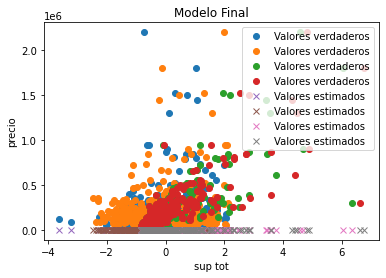

In [41]:
plot_regression(modelo2,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

## Clasificación: